In [3]:
"""
Covariance & Correlation Matrices: A Practical Deep Dive
========================================================

This explores multivariate relationships in linear regression.
Moving from pairs of variables (X,Y) to many variables at once.

Domain: Microservices - Predicting response time from multiple factors
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(42)
sns.set_style("whitegrid")

# Create output directory if it doesn't exist
output_dir = 'user-data/outputs'
os.makedirs(output_dir, exist_ok=True)

In [4]:
# ============================================================================
# PART 1: FROM PAIRS TO MATRICES - MENTAL MODEL
# ============================================================================

print("\n" + "="*70)
print("PART 1: FROM PAIRS OF VARIABLES TO MULTIVARIATE THINKING")
print("="*70)

"""
Single Variable (Univariate):
  Series: [1, 2, 3, 4, 5]
  Summary: mean, variance
  
Two Variables (Bivariate):
  X: [1, 2, 3, 4, 5]
  Y: [2, 4, 6, 8, 10]
  Relationship: correlation or covariance between X and Y
  
Many Variables (Multivariate):
  X₁: queue_depth
  X₂: cpu_usage
  X₃: memory_usage
  X₄: gc_pauses
  X₅: active_connections
  
  Question: How do ALL these relate to each other?
  Answer: Covariance matrix (or correlation matrix)
"""

# Create a realistic microservices dataset
n_samples = 200

queue_depth = np.random.uniform(10, 100, n_samples)
cpu_usage = 30 + 0.4*queue_depth + np.random.normal(0, 5, n_samples)
memory_usage = 40 + 0.3*queue_depth + 0.2*cpu_usage + np.random.normal(0, 8, n_samples)
gc_pauses = 2 + 0.01*queue_depth + 0.05*memory_usage + np.random.normal(0, 0.5, n_samples)
active_connections = 50 + 0.8*queue_depth + np.random.normal(0, 10, n_samples)

# Target variable
response_time = (50 + 
                 1.5*queue_depth + 
                 0.3*cpu_usage + 
                 0.1*memory_usage + 
                 5*gc_pauses + 
                 0.05*active_connections + 
                 np.random.normal(0, 10, n_samples))

# Create dataframe
data = pd.DataFrame({
    'queue_depth': queue_depth,
    'cpu_usage': cpu_usage,
    'memory_usage': memory_usage,
    'gc_pauses': gc_pauses,
    'active_connections': active_connections,
    'response_time': response_time
})

print("\nMicroservices Metrics Dataset:")
print(data.describe().round(2))
print(f"\nDataset shape: {data.shape} (200 observations × 6 variables)")


PART 1: FROM PAIRS OF VARIABLES TO MULTIVARIATE THINKING

Microservices Metrics Dataset:
       queue_depth  cpu_usage  memory_usage  gc_pauses  active_connections  \
count       200.00     200.00        200.00     200.00              200.00   
mean         53.56      51.76         65.97       5.82               94.59   
std          26.54      11.56         13.19       1.04               23.97   
min          10.50      28.22         37.67       3.52               44.18   
25%          30.57      41.33         56.40       5.12               74.99   
50%          54.50      51.25         64.46       5.69               92.63   
75%          78.12      61.86         76.65       6.57              115.25   
max          98.82      75.87        102.48       8.43              143.15   

       response_time  
count         200.00  
mean          187.56  
std            51.02  
min            88.18  
25%           144.85  
50%           183.35  
75%           226.42  
max           282.33  


In [5]:
# ============================================================================
# PART 2: UNDERSTANDING COVARIANCE
# ============================================================================

print("\n" + "="*70)
print("PART 2: COVARIANCE - HOW DO TWO VARIABLES VARY TOGETHER?")
print("="*70)

"""
COVARIANCE measures how two variables move together.

Formula:
  cov(X, Y) = Σ(Xᵢ - X_mean)(Yᵢ - Y_mean) / (n - 1)

Interpretation:
  > 0: Positive relationship (both increase together)
  < 0: Negative relationship (one increases, other decreases)
  ≈ 0: No relationship
  
PROBLEM: Covariance scale depends on data scale!
  - If X is in milliseconds and Y is in seconds, cov is hard to interpret
  - Makes comparison across different variables difficult
  
SOLUTION: Correlation (standardized covariance)
"""

# Calculate covariance between two variables
cov_queue_cpu = np.cov(data['queue_depth'], data['cpu_usage'])[0, 1]
cov_queue_gc = np.cov(data['queue_depth'], data['gc_pauses'])[0, 1]
cov_cpu_memory = np.cov(data['cpu_usage'], data['memory_usage'])[0, 1]
cov_queue_response = np.cov(data['queue_depth'], data['response_time'])[0, 1]

print("\nPairwise Covariances:")
print(f"  cov(queue_depth, cpu_usage) = {cov_queue_cpu:.2f}")
print(f"    → Positive: higher queue → higher CPU ✓")
print(f"\n  cov(queue_depth, gc_pauses) = {cov_queue_gc:.2f}")
print(f"    → Positive: higher queue → more GC pauses ✓")
print(f"\n  cov(cpu_usage, memory_usage) = {cov_cpu_memory:.2f}")
print(f"    → Positive: higher CPU → higher memory ✓")
print(f"\n  cov(queue_depth, response_time) = {cov_queue_response:.2f}")
print(f"    → Positive: higher queue → slower response ✓")

print("\nProblem: Hard to compare these!")
print("  Is 180 'stronger' than 400? Different scales make it confusing.")
print("  → Solution: Use CORRELATION (next)")


PART 2: COVARIANCE - HOW DO TWO VARIABLES VARY TOGETHER?

Pairwise Covariances:
  cov(queue_depth, cpu_usage) = 278.70
    → Positive: higher queue → higher CPU ✓

  cov(queue_depth, gc_pauses) = 21.14
    → Positive: higher queue → more GC pauses ✓

  cov(cpu_usage, memory_usage) = 111.98
    → Positive: higher CPU → higher memory ✓

  cov(queue_depth, response_time) = 1324.16
    → Positive: higher queue → slower response ✓

Problem: Hard to compare these!
  Is 180 'stronger' than 400? Different scales make it confusing.
  → Solution: Use CORRELATION (next)



PART 3: CORRELATION - STANDARDIZED RELATIONSHIP

Pairwise Correlations (r):
  r(queue_depth, cpu_usage) = 0.908  [Strong positive]
  r(queue_depth, gc_pauses) = 0.762  [Moderate positive]
  r(cpu_usage, memory_usage) = 0.734  [Strong positive]
  r(queue_depth, response_time) = 0.978  [Strong positive] ← Key predictor!
  r(active_connections, response_time) = 0.914  [Strong positive]
  r(memory_usage, response_time) = 0.804  [Weak positive]

Key Insight:
  All correlations are 0 to 1, so we can compare directly!
  queue_depth is the strongest predictor of response_time ✓

✓ Saved: 01_correlation_strengths.png


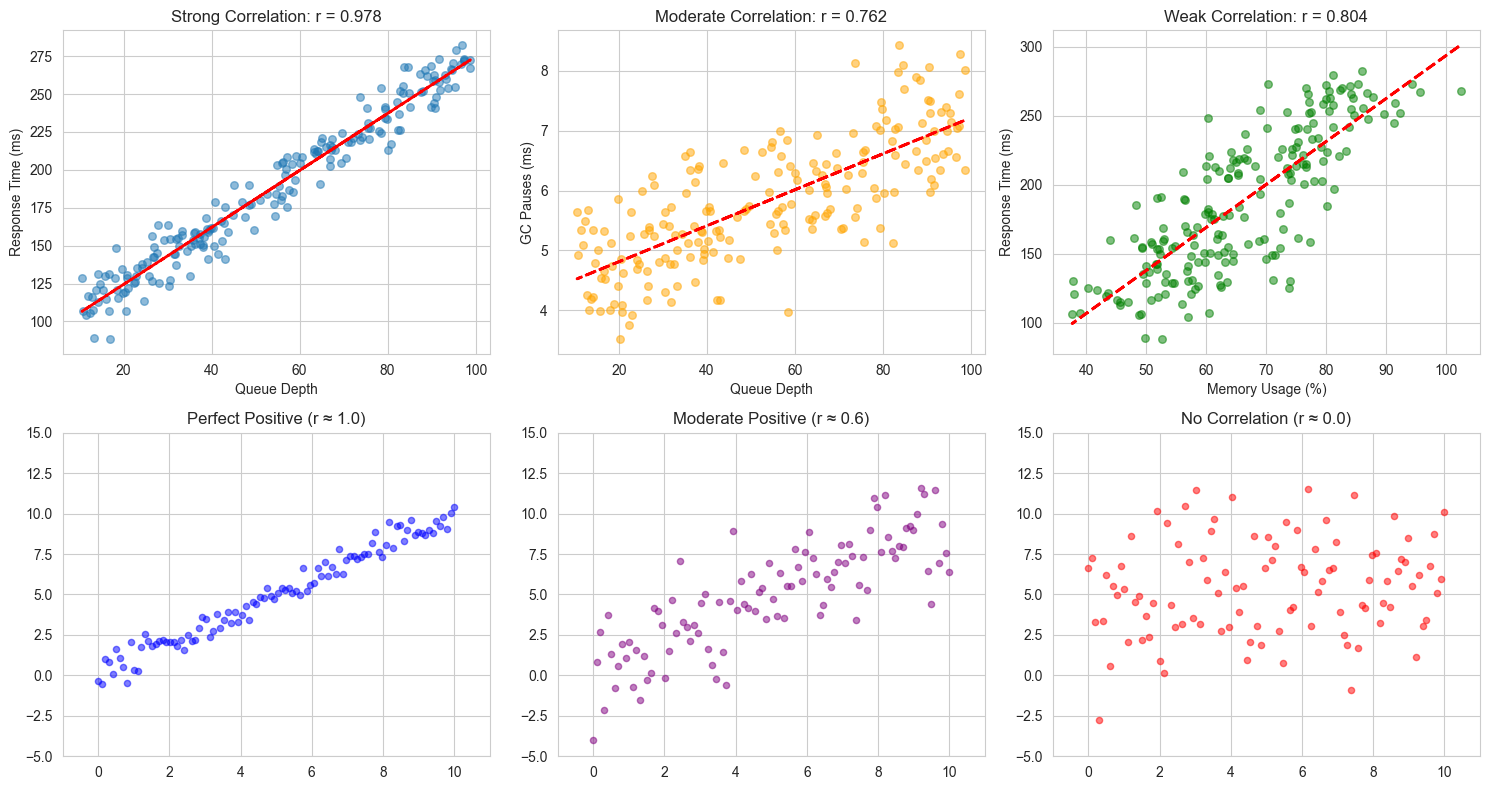

In [6]:
# ============================================================================
# PART 3: UNDERSTANDING CORRELATION (STANDARDIZED COVARIANCE)
# ============================================================================

print("\n" + "="*70)
print("PART 3: CORRELATION - STANDARDIZED RELATIONSHIP")
print("="*70)

"""
CORRELATION = Covariance / (std_dev_X * std_dev_Y)

Also called: Pearson Correlation Coefficient
Denoted by: r or ρ (rho)

Properties:
  Range: -1 to +1 (always!)
  +1: Perfect positive relationship
   0: No relationship
  -1: Perfect negative relationship
   
Interpretation:
  0.7 to 1.0: Strong positive
  0.4 to 0.7: Moderate positive
  0.0 to 0.4: Weak positive
  -0.4 to 0.0: Weak negative
  -0.7 to -0.4: Moderate negative
  -1.0 to -0.7: Strong negative
"""

# Calculate Pearson correlation
corr_queue_cpu = data['queue_depth'].corr(data['cpu_usage'])
corr_queue_gc = data['queue_depth'].corr(data['gc_pauses'])
corr_cpu_memory = data['cpu_usage'].corr(data['memory_usage'])
corr_queue_response = data['queue_depth'].corr(data['response_time'])
corr_active_response = data['active_connections'].corr(data['response_time'])
corr_memory_response = data['memory_usage'].corr(data['response_time'])

print("\nPairwise Correlations (r):")
print(f"  r(queue_depth, cpu_usage) = {corr_queue_cpu:.3f}  [Strong positive]")
print(f"  r(queue_depth, gc_pauses) = {corr_queue_gc:.3f}  [Moderate positive]")
print(f"  r(cpu_usage, memory_usage) = {corr_cpu_memory:.3f}  [Strong positive]")
print(f"  r(queue_depth, response_time) = {corr_queue_response:.3f}  [Strong positive] ← Key predictor!")
print(f"  r(active_connections, response_time) = {corr_active_response:.3f}  [Strong positive]")
print(f"  r(memory_usage, response_time) = {corr_memory_response:.3f}  [Weak positive]")

print("\nKey Insight:")
print("  All correlations are 0 to 1, so we can compare directly!")
print("  queue_depth is the strongest predictor of response_time ✓")

# Visualize correlations with scatter plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Strong positive
ax = axes[0, 0]
ax.scatter(data['queue_depth'], data['response_time'], alpha=0.5, s=30)
ax.set_xlabel('Queue Depth')
ax.set_ylabel('Response Time (ms)')
ax.set_title(f'Strong Correlation: r = {corr_queue_response:.3f}')
z = np.polyfit(data['queue_depth'], data['response_time'], 1)
p = np.poly1d(z)
ax.plot(data['queue_depth'], p(data['queue_depth']), "r--", linewidth=2)

# Moderate positive
ax = axes[0, 1]
ax.scatter(data['queue_depth'], data['gc_pauses'], alpha=0.5, s=30, color='orange')
ax.set_xlabel('Queue Depth')
ax.set_ylabel('GC Pauses (ms)')
ax.set_title(f'Moderate Correlation: r = {corr_queue_gc:.3f}')
z = np.polyfit(data['queue_depth'], data['gc_pauses'], 1)
p = np.poly1d(z)
ax.plot(data['queue_depth'], p(data['queue_depth']), "r--", linewidth=2)

# Weak positive
ax = axes[0, 2]
ax.scatter(data['memory_usage'], data['response_time'], alpha=0.5, s=30, color='green')
ax.set_xlabel('Memory Usage (%)')
ax.set_ylabel('Response Time (ms)')
ax.set_title(f'Weak Correlation: r = {corr_memory_response:.3f}')
z = np.polyfit(data['memory_usage'], data['response_time'], 1)
p = np.poly1d(z)
ax.plot(data['memory_usage'], p(data['memory_usage']), "r--", linewidth=2)

# Show different correlation strengths synthetically
ax = axes[1, 0]
# Perfect positive
x = np.linspace(0, 10, 100)
y_perfect = x + np.random.normal(0, 0.5, 100)
ax.scatter(x, y_perfect, alpha=0.5, s=20, color='blue')
ax.set_title('Perfect Positive (r ≈ 1.0)')
ax.set_xlim(-1, 11)
ax.set_ylim(-5, 15)

ax = axes[1, 1]
# Moderate positive
y_moderate = x + np.random.normal(0, 2, 100)
ax.scatter(x, y_moderate, alpha=0.5, s=20, color='purple')
ax.set_title('Moderate Positive (r ≈ 0.6)')
ax.set_xlim(-1, 11)
ax.set_ylim(-5, 15)

ax = axes[1, 2]
# No correlation
y_none = np.random.normal(5, 3, 100)
ax.scatter(x, y_none, alpha=0.5, s=20, color='red')
ax.set_title('No Correlation (r ≈ 0.0)')
ax.set_xlim(-1, 11)
ax.set_ylim(-5, 15)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '01_correlation_strengths.png'), dpi=100)
print("\n✓ Saved: 01_correlation_strengths.png")


PART 4: COVARIANCE MATRIX - THE FULL PICTURE

Covariance Matrix:
                    queue_depth  cpu_usage  memory_usage  gc_pauses  \
queue_depth              704.38     278.70        277.39      21.14   
cpu_usage                278.70     133.73        111.98       8.30   
memory_usage             277.39     111.98        173.98      11.95   
gc_pauses                 21.14       8.30         11.95       1.09   
active_connections       585.29     230.09        229.22      18.17   

                    active_connections  
queue_depth                     585.29  
cpu_usage                       230.09  
memory_usage                    229.22  
gc_pauses                        18.17  
active_connections              574.61  

Diagonal (Variances):
  var(queue_depth) = 704.38, std = 26.54
  var(cpu_usage) = 133.73, std = 11.56
  var(memory_usage) = 173.98, std = 13.19
  var(gc_pauses) = 1.09, std = 1.04
  var(active_connections) = 574.61, std = 23.97

Interpretation:
  - Diagonal: H

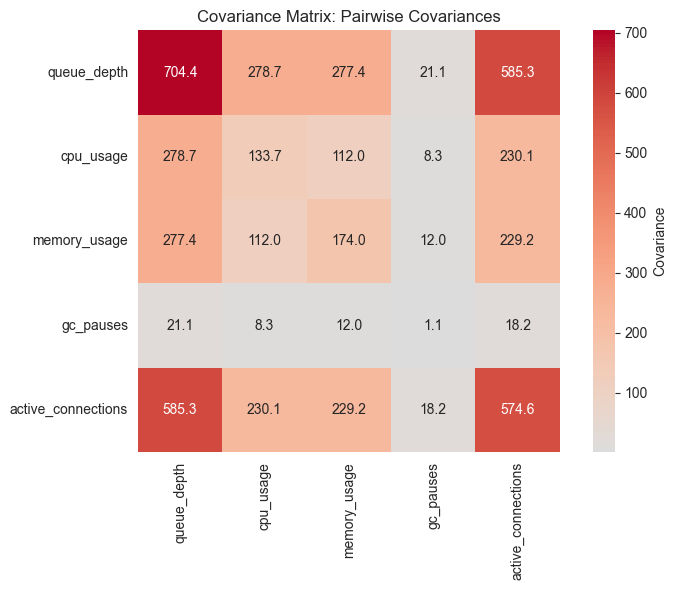

In [7]:
# ============================================================================
# PART 4: COVARIANCE MATRIX - ALL PAIRWISE COVARIANCES
# ============================================================================

print("\n" + "="*70)
print("PART 4: COVARIANCE MATRIX - THE FULL PICTURE")
print("="*70)

"""
Covariance Matrix: A matrix where element (i,j) = cov(Xᵢ, Xⱼ)

Example (4 variables):
       X₁    X₂    X₃    X₄
X₁ [  var₁  cov₁₂ cov₁₃ cov₁₄ ]
X₂ [  cov₂₁ var₂  cov₂₃ cov₂₄ ]
X₃ [  cov₃₁ cov₃₂ var₃  cov₃₄ ]
X₄ [  cov₄₁ cov₄₂ cov₄₃ var₄  ]

Properties:
  - Diagonal = variances (variance of each variable with itself)
  - Symmetric: cov(X,Y) = cov(Y,X)
  - Square: n × n matrix for n variables
"""

# Calculate covariance matrix (using only predictors, not response)
features = ['queue_depth', 'cpu_usage', 'memory_usage', 'gc_pauses', 'active_connections']
cov_matrix = data[features].cov()

print("\nCovariance Matrix:")
print(cov_matrix.round(2))

print("\nDiagonal (Variances):")
for feat in features:
    var = cov_matrix.loc[feat, feat]
    std = np.sqrt(var)
    print(f"  var({feat}) = {var:.2f}, std = {std:.2f}")

print("\nInterpretation:")
print("  - Diagonal: How much each variable varies by itself")
print("  - Off-diagonal: How variables co-vary (move together)")
print("  - Symmetric: cov(X,Y) always equals cov(Y,X)")

# Visualize covariance matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, fmt='.1f', cmap='coolwarm', center=0,
            square=True, ax=ax, cbar_kws={'label': 'Covariance'})
ax.set_title('Covariance Matrix: Pairwise Covariances')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '02_covariance_matrix.png'), dpi=100)
print("\n✓ Saved: 02_covariance_matrix.png")


PART 5: CORRELATION MATRIX - STANDARDIZED COVARIANCE

Correlation Matrix (all variables including response_time):
                    queue_depth  cpu_usage  memory_usage  gc_pauses  \
queue_depth               1.000      0.908         0.792      0.762   
cpu_usage                 0.908      1.000         0.734      0.687   
memory_usage              0.792      0.734         1.000      0.867   
gc_pauses                 0.762      0.687         0.867      1.000   
active_connections        0.920      0.830         0.725      0.726   
response_time             0.978      0.899         0.804      0.791   

                    active_connections  response_time  
queue_depth                      0.920          0.978  
cpu_usage                        0.830          0.899  
memory_usage                     0.725          0.804  
gc_pauses                        0.726          0.791  
active_connections               1.000          0.914  
response_time                    0.914          1.0

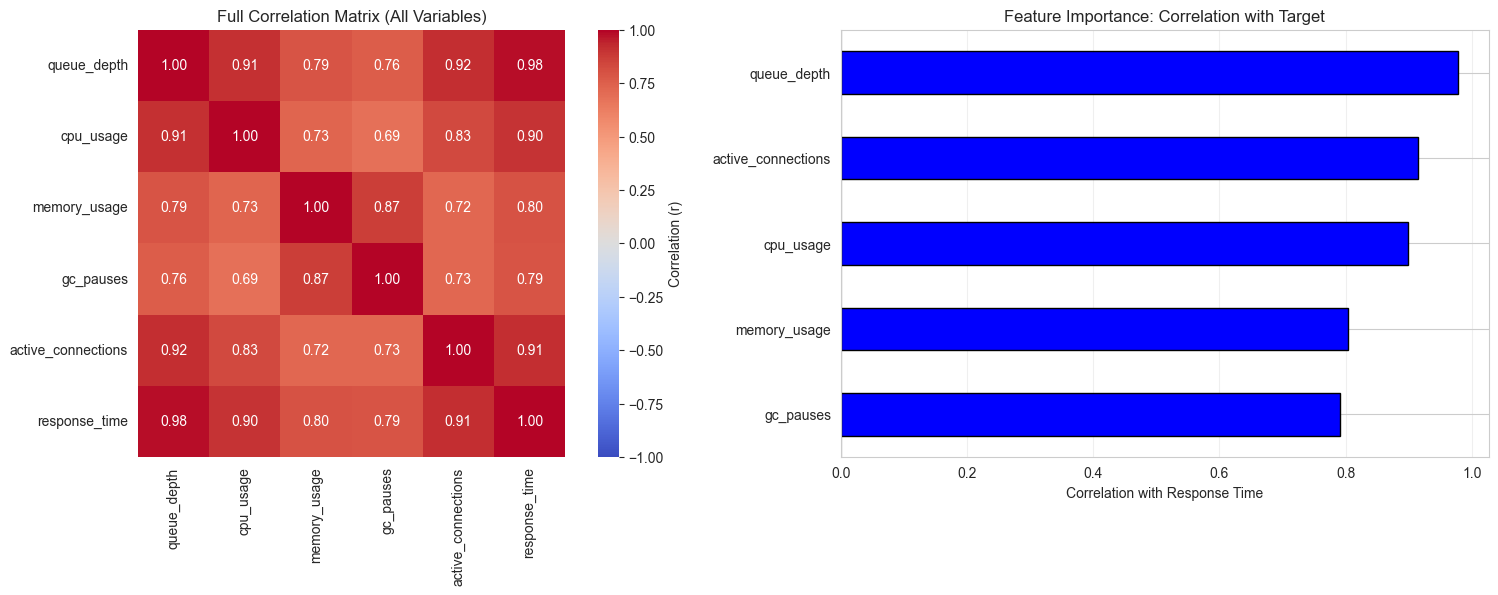

In [8]:
# ============================================================================
# PART 5: CORRELATION MATRIX - STANDARDIZED RELATIONSHIPS
# ============================================================================

print("\n" + "="*70)
print("PART 5: CORRELATION MATRIX - STANDARDIZED COVARIANCE")
print("="*70)

"""
Correlation Matrix: Standardized version of covariance matrix

Element (i,j) = cov(Xᵢ, Xⱼ) / (std(Xᵢ) × std(Xⱼ))

Benefits over covariance matrix:
  - Always between -1 and +1 (easier to interpret)
  - Scale-invariant (can compare across different units)
  - Diagonal is always 1.0 (perfect correlation with itself)
  
Use correlation matrix for:
  - Comparing relationship strengths
  - Feature selection (which variables matter most)
  - Detecting multicollinearity (too many correlated features)
"""

# Calculate correlation matrix
corr_matrix = data[features + ['response_time']].corr()

print("\nCorrelation Matrix (all variables including response_time):")
print(corr_matrix.round(3))

print("\nKey Correlations with Response Time:")
response_corr = corr_matrix['response_time'].drop('response_time').sort_values(ascending=False)
for var, corr_val in response_corr.items():
    strength = 'Strong' if abs(corr_val) > 0.7 else 'Moderate' if abs(corr_val) > 0.4 else 'Weak'
    print(f"  r({var}, response_time) = {corr_val:.3f}  [{strength}]")

# Visualize correlation matrix with heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full correlation matrix
ax = axes[0]
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, ax=ax, cbar_kws={'label': 'Correlation (r)'},
            vmin=-1, vmax=1)
ax.set_title('Full Correlation Matrix (All Variables)')

# Correlation with response_time only
ax = axes[1]
response_corr_df = corr_matrix[['response_time']].drop('response_time').sort_values('response_time')
colors = ['red' if x < 0 else 'blue' for x in response_corr_df['response_time']]
response_corr_df['response_time'].plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.set_xlabel('Correlation with Response Time')
ax.set_title('Feature Importance: Correlation with Target')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '03_correlation_matrix_heatmap.png'), dpi=100)
print("\n✓ Saved: 03_correlation_matrix_heatmap.png")


PART 6: MULTICOLLINEARITY - WHEN FEATURES CORRELATE TOO MUCH

Detecting Multicollinearity:

1. HIGH CORRELATIONS IN PREDICTOR SPACE:

Predictor Correlations (ignoring response for now):
                    queue_depth  cpu_usage  memory_usage  gc_pauses  \
queue_depth               1.000      0.908         0.792      0.762   
cpu_usage                 0.908      1.000         0.734      0.687   
memory_usage              0.792      0.734         1.000      0.867   
gc_pauses                 0.762      0.687         0.867      1.000   
active_connections        0.920      0.830         0.725      0.726   

                    active_connections  
queue_depth                      0.920  
cpu_usage                        0.830  
memory_usage                     0.725  
gc_pauses                        0.726  
active_connections               1.000  

⚠️  HIGH CORRELATIONS DETECTED:
  queue_depth ↔ cpu_usage: r = 0.908
  queue_depth ↔ memory_usage: r = 0.792
  queue_depth ↔ gc_pauses: r =

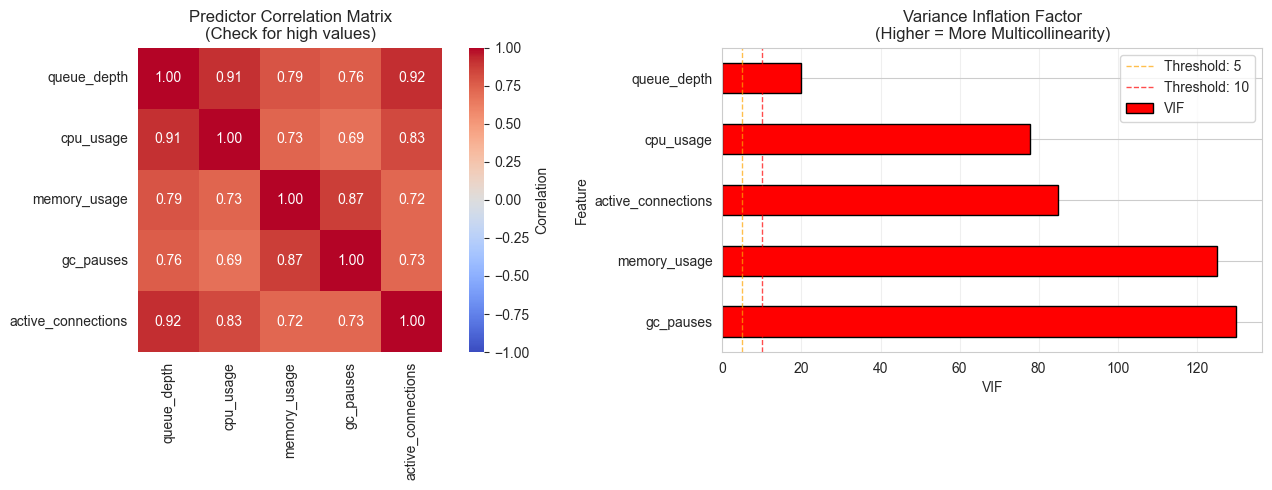

In [9]:
# ============================================================================
# PART 6: MULTICOLLINEARITY - THE CORRELATION PROBLEM
# ============================================================================

print("\n" + "="*70)
print("PART 6: MULTICOLLINEARITY - WHEN FEATURES CORRELATE TOO MUCH")
print("="*70)

"""
MULTICOLLINEARITY: When predictor variables correlate with each other.

Problem: If X₁ and X₂ are highly correlated, the model can't tell 
which one truly drives the outcome. Coefficients become unstable.

Example: 
  - CPU usage and memory usage are highly correlated
  - Both increase together due to same underlying workload
  - Model might randomly assign importance to either one
  - This makes predictions unreliable
  
Detection:
  1. Correlation matrix: Look for high correlations (|r| > 0.8)
  2. VIF (Variance Inflation Factor): VIF > 5 or 10 indicates problem
  
Solutions:
  1. Remove one correlated feature
  2. Combine features (PCA, domain knowledge)
  3. Use regularization (Ridge, Lasso regression)
"""

print("\nDetecting Multicollinearity:")
print("\n1. HIGH CORRELATIONS IN PREDICTOR SPACE:")

# Check predictor-predictor correlations
pred_corr_matrix = data[features].corr()
print("\nPredictor Correlations (ignoring response for now):")
print(pred_corr_matrix.round(3))

# Find high correlations
high_corr_pairs = []
for i in range(len(pred_corr_matrix.columns)):
    for j in range(i+1, len(pred_corr_matrix.columns)):
        corr_val = pred_corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            var1 = pred_corr_matrix.columns[i]
            var2 = pred_corr_matrix.columns[j]
            high_corr_pairs.append((var1, var2, corr_val))

if high_corr_pairs:
    print("\n⚠️  HIGH CORRELATIONS DETECTED:")
    for var1, var2, corr_val in high_corr_pairs:
        print(f"  {var1} ↔ {var2}: r = {corr_val:.3f}")
else:
    print("\n✓ No extreme multicollinearity detected")

# Calculate VIF (Variance Inflation Factor)
print("\n2. VARIANCE INFLATION FACTOR (VIF):")
print("  VIF = 1 / (1 - R²ᵢ)")
print("  where R²ᵢ = R² when Xᵢ is predicted by all other X's")
print("\n  Interpretation:")
print("    VIF ≈ 1: No correlation problem")
print("    VIF > 5: Moderate concern")
print("    VIF > 10: Serious concern")

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = features
vif_data["VIF"] = [variance_inflation_factor(data[features].values, i) 
                    for i in range(len(features))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\nVIF for Each Feature:")
print(vif_data.to_string(index=False))

# Visualize multicollinearity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation matrix heatmap (predictors only)
ax = axes[0]
sns.heatmap(pred_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, ax=ax, cbar_kws={'label': 'Correlation'},
            vmin=-1, vmax=1)
ax.set_title('Predictor Correlation Matrix\n(Check for high values)')

# VIF bar plot
ax = axes[1]
colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in vif_data['VIF']]
vif_data.plot(x='Feature', y='VIF', kind='barh', ax=ax, legend=False, color=colors, edgecolor='black')
ax.set_xlabel('VIF')
ax.set_title('Variance Inflation Factor\n(Higher = More Multicollinearity)')
ax.axvline(5, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Threshold: 5')
ax.axvline(10, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Threshold: 10')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '04_multicollinearity_detection.png'), dpi=100)

print("\n✓ Saved: 04_multicollinearity_detection.png")


PART 7: HOW CORRELATION INFORMS FEATURE SELECTION

Feature Selection Strategy Based on Correlation:

1. Features vs Target (response_time):
  queue_depth: r = 0.978  [KEEP]
  active_connections: r = 0.914  [KEEP]
  cpu_usage: r = 0.899  [KEEP]
  memory_usage: r = 0.804  [KEEP]
  gc_pauses: r = 0.791  [KEEP]

2. After target-based selection, kept features: ['queue_depth', 'active_connections', 'cpu_usage', 'memory_usage', 'gc_pauses']

Predictor correlations among kept features:
                    queue_depth  active_connections  cpu_usage  memory_usage  \
queue_depth               1.000               0.920      0.908         0.792   
active_connections        0.920               1.000      0.830         0.725   
cpu_usage                 0.908               0.830      1.000         0.734   
memory_usage              0.792               0.725      0.734         1.000   
gc_pauses                 0.762               0.726      0.687         0.867   

                    gc_pauses  
que

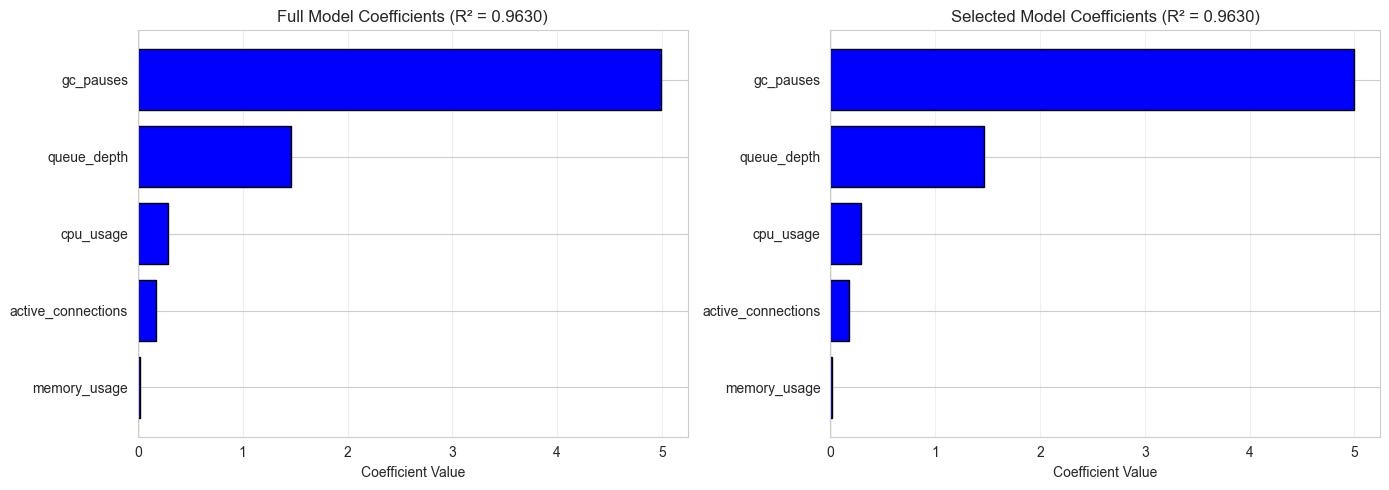

In [10]:
# ============================================================================
# PART 7: FROM CORRELATION TO LINEAR REGRESSION
# ============================================================================

print("\n" + "="*70)
print("PART 7: HOW CORRELATION INFORMS FEATURE SELECTION")
print("="*70)

"""
The correlation matrix is your feature selection tool!

Strategy:
  1. Correlate each feature with the target
     → Keep features highly correlated with target
     → Drop features weakly correlated with target
  
  2. Check predictor-predictor correlations
     → If two features are highly correlated
     → Keep the one more correlated with target
     → Drop the other (reduces multicollinearity)
  
  3. Fit regression model with selected features
     → More stable coefficients
     → Better generalization
     → Interpretable results
"""

print("\nFeature Selection Strategy Based on Correlation:")

# 1. Correlation with target
print("\n1. Features vs Target (response_time):")
target_corr = corr_matrix['response_time'].drop('response_time').abs().sort_values(ascending=False)
for var, corr_val in target_corr.items():
    decision = "KEEP" if abs(corr_val) > 0.4 else "CONSIDER DROPPING"
    print(f"  {var}: r = {target_corr[var]:.3f}  [{decision}]")

# 2. Check multicollinearity among kept features
kept_features = target_corr[target_corr > 0.4].index.tolist()
print(f"\n2. After target-based selection, kept features: {kept_features}")

pred_corr_kept = data[kept_features].corr()
print("\nPredictor correlations among kept features:")
print(pred_corr_kept.round(3))

# 3. Fit models: Full vs Selected
print("\n3. Model Performance Comparison:")

# Full model (all features)
X_full = data[features]
y = data['response_time']

model_full = LinearRegression()
model_full.fit(X_full, y)
y_pred_full = model_full.predict(X_full)
r2_full = r2_score(y, y_pred_full)

# Selected model (high correlation features)
X_selected = data[kept_features]
model_selected = LinearRegression()
model_selected.fit(X_selected, y)
y_pred_selected = model_selected.predict(X_selected)
r2_selected = r2_score(y, y_pred_selected)

print(f"\nFull Model (all {len(features)} features):")
print(f"  R² = {r2_full:.4f}")
print(f"  RMSE = {np.sqrt(np.mean((y - y_pred_full)**2)):.2f}")
print(f"  Coefficients: {dict(zip(features, model_full.coef_))}")

print(f"\nSelected Model ({len(kept_features)} features):")
print(f"  R² = {r2_selected:.4f}")
print(f"  RMSE = {np.sqrt(np.mean((y - y_pred_selected)**2)):.2f}")
print(f"  Coefficients: {dict(zip(kept_features, model_selected.coef_))}")

print("\nKey Insight:")
diff_r2 = r2_full - r2_selected
if diff_r2 < 0.01:
    print(f"  ✓ Minimal R² loss ({diff_r2:.4f}) while reducing features")
    print(f"  → Selected model is simpler and more interpretable!")
else:
    print(f"  Model performance differs by {diff_r2:.4f}")

# Visualize model coefficients
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full model coefficients
ax = axes[0]
coef_df_full = pd.DataFrame({'Feature': features, 'Coefficient': model_full.coef_})
coef_df_full['Abs'] = np.abs(coef_df_full['Coefficient'])
coef_df_full = coef_df_full.sort_values('Abs')
colors_full = ['red' if x < 0 else 'blue' for x in coef_df_full['Coefficient']]
ax.barh(coef_df_full['Feature'], coef_df_full['Coefficient'], color=colors_full, edgecolor='black')
ax.set_xlabel('Coefficient Value')
ax.set_title(f'Full Model Coefficients (R² = {r2_full:.4f})')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Selected model coefficients
ax = axes[1]
coef_df_selected = pd.DataFrame({'Feature': kept_features, 'Coefficient': model_selected.coef_})
coef_df_selected['Abs'] = np.abs(coef_df_selected['Coefficient'])
coef_df_selected = coef_df_selected.sort_values('Abs')
colors_selected = ['red' if x < 0 else 'blue' for x in coef_df_selected['Coefficient']]
ax.barh(coef_df_selected['Feature'], coef_df_selected['Coefficient'], color=colors_selected, edgecolor='black')
ax.set_xlabel('Coefficient Value')
ax.set_title(f'Selected Model Coefficients (R² = {r2_selected:.4f})')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '05_feature_selection_comparison.png'), dpi=100)

print("\n✓ Saved: 05_feature_selection_comparison.png")


PART 8: BONUS - EIGENVALUES & EIGENVECTORS OF CORRELATION MATRIX

Eigenvalues of Predictor Correlation Matrix:
  PC1: λ = 4.184 (83.7% of variance)
  PC2: λ = 0.461 (9.2% of variance)
  PC3: λ = 0.181 (3.6% of variance)
  PC4: λ = 0.121 (2.4% of variance)
  PC5: λ = 0.054 (1.1% of variance)

Cumulative Variance Explained:
  First 1 components: 83.7%
  First 2 components: 92.9%
  First 3 components: 96.5%
  First 4 components: 98.9%
  First 5 components: 100.0%

✓ Saved: 06_eigenvalues_pca.png


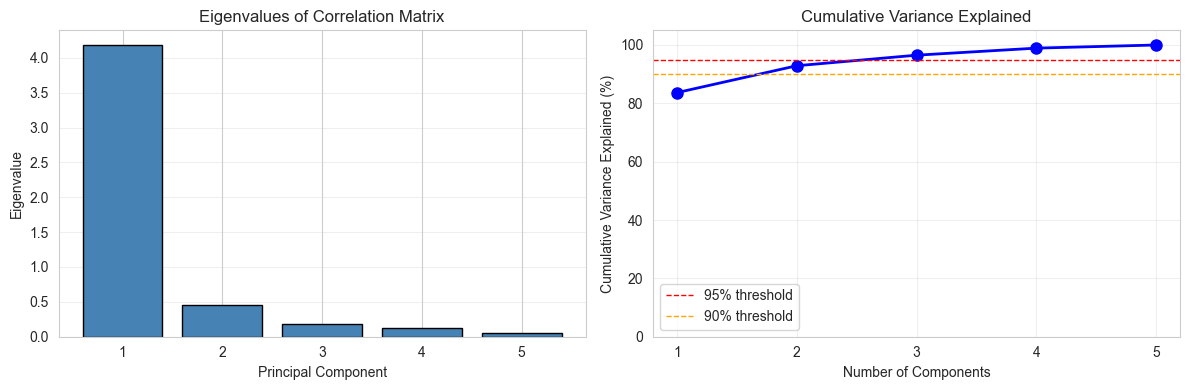

In [11]:
# ============================================================================
# PART 8: UNDERSTANDING EIGENVALUES & EIGENVECTORS (BONUS)
# ============================================================================

print("\n" + "="*70)
print("PART 8: BONUS - EIGENVALUES & EIGENVECTORS OF CORRELATION MATRIX")
print("="*70)

"""
Eigenvalues tell you the "importance" of directions in your data.

For correlation matrix:
  - Sum of eigenvalues = number of variables
  - Large eigenvalue = data varies a lot in that direction
  - Small eigenvalue = little variance in that direction
  
Use case: Principal Component Analysis (PCA) - future topic!
  - Keep components with large eigenvalues
  - Drop components with small eigenvalues
  - Reduces dimensionality while preserving information
"""

eigenvalues, eigenvectors = np.linalg.eig(pred_corr_matrix)
eigenvalues = np.sort(eigenvalues)[::-1]  # Sort descending

print(f"\nEigenvalues of Predictor Correlation Matrix:")
for i, ev in enumerate(eigenvalues, 1):
    pct_variance = (ev / eigenvalues.sum()) * 100
    print(f"  PC{i}: λ = {ev:.3f} ({pct_variance:.1f}% of variance)")

cumsum_variance = np.cumsum(eigenvalues / eigenvalues.sum()) * 100
print(f"\nCumulative Variance Explained:")
for i, cum_var in enumerate(cumsum_variance, 1):
    print(f"  First {i} components: {cum_var:.1f}%")

# Visualize eigenvalues
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Eigenvalues bar plot
ax = axes[0]
ax.bar(range(1, len(eigenvalues)+1), eigenvalues, color='steelblue', edgecolor='black')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue')
ax.set_title('Eigenvalues of Correlation Matrix')
ax.set_xticks(range(1, len(eigenvalues)+1))
ax.grid(True, alpha=0.3, axis='y')

# Cumulative variance explained
ax = axes[1]
ax.plot(range(1, len(cumsum_variance)+1), cumsum_variance, 'bo-', linewidth=2, markersize=8)
ax.axhline(95, color='r', linestyle='--', linewidth=1, label='95% threshold')
ax.axhline(90, color='orange', linestyle='--', linewidth=1, label='90% threshold')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Variance Explained (%)')
ax.set_title('Cumulative Variance Explained')
ax.set_xticks(range(1, len(cumsum_variance)+1))
ax.set_ylim(0, 105)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '06_eigenvalues_pca.png'), dpi=100)

print("\n✓ Saved: 06_eigenvalues_pca.png")

In [12]:
# ============================================================================
# PART 9: PARETO ESSENTIALS - MIND MAP
# ============================================================================

print("\n" + "="*70)
print("PART 9: PARETO ESSENTIALS FOR COVARIANCE & CORRELATION")
print("="*70)

pareto_map = """
┌─ COVARIANCE & CORRELATION MATRICES ────────────────────────────────┐
│                                                                     │
│  ROOT: Multivariate Relationships                                  │
│  └─ Going from 2 variables to many variables                       │
│                                                                     │
│  BRANCH 1: UNDERSTANDING COVARIANCE                                │
│  ├─ Measures how two variables move together                       │
│  ├─ Formula: cov(X,Y) = Σ(Xᵢ-μₓ)(Yᵢ-μᵧ)/(n-1)                   │
│  ├─ > 0: Positive relationship                                     │
│  ├─ < 0: Negative relationship                                     │
│  ├─ ≈ 0: No relationship                                           │
│  └─ PROBLEM: Scale-dependent (hard to compare)                    │
│                                                                     │
│  BRANCH 2: CORRELATION (STANDARDIZED COVARIANCE)                  │
│  ├─ Formula: r = cov(X,Y) / (σₓ × σᵧ)                             │
│  ├─ Range: -1 to +1 (always!)                                     │
│  ├─ +1: Perfect positive relationship                              │
│  ├─ 0: No relationship                                             │
│  ├─ -1: Perfect negative relationship                              │
│  └─ BENEFIT: Scale-independent, easy to compare                   │
│                                                                     │
│  BRANCH 3: COVARIANCE MATRIX                                       │
│  ├─ Matrix of all pairwise covariances                             │
│  ├─ Diagonal = variances of each variable                          │
│  ├─ Off-diagonal = covariances between pairs                       │
│  ├─ Symmetric: cov(X,Y) = cov(Y,X)                                │
│  └─ Use: Understanding overall variance structure                 │
│                                                                     │
│  BRANCH 4: CORRELATION MATRIX                                      │
│  ├─ Standardized version of covariance matrix                      │
│  ├─ All entries between -1 and +1                                 │
│  ├─ Diagonal = 1.0 (perfect correlation with self)                │
│  ├─ Visual: Heatmap for easy pattern recognition                  │
│  └─ KEY USE: Feature selection and multicollinearity check        │
│                                                                     │
│  BRANCH 5: MULTICOLLINEARITY (THE PROBLEM)                        │
│  ├─ When predictors correlate with each other                     │
│  ├─ Detection: High pairwise correlations (|r| > 0.8)             │
│  ├─ Or: High VIF scores (VIF > 5 or 10)                           │
│  ├─ Problem: Unstable coefficients, poor generalization           │
│  └─ Solutions: Remove features, combine, or use regularization   │
│                                                                     │
│  BRANCH 6: FEATURE SELECTION WORKFLOW                              │
│  ├─ 1. Correlate each feature with target                         │
│  ├─ 2. Keep highly correlated features (|r| > 0.4)               │
│  ├─ 3. Check predictor-predictor correlations                     │
│  ├─ 4. If high, keep one and drop others                          │
│  └─ 5. Fit model with selected features                           │
│                                                                     │
│  THE 20% THAT MATTERS:                                             │
│  ✓ Correlation: standardized measure of relationship              │
│  ✓ Correlation matrix: see all relationships at once              │
│  ✓ Feature selection: correlate with target, keep strong          │
│  ✓ Multicollinearity: check VIF or pairwise correlations         │
│  ✓ Simple beats complex: fewer features if possible               │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
"""

print(pareto_map)


PART 9: PARETO ESSENTIALS FOR COVARIANCE & CORRELATION

┌─ COVARIANCE & CORRELATION MATRICES ────────────────────────────────┐
│                                                                     │
│  ROOT: Multivariate Relationships                                  │
│  └─ Going from 2 variables to many variables                       │
│                                                                     │
│  BRANCH 1: UNDERSTANDING COVARIANCE                                │
│  ├─ Measures how two variables move together                       │
│  ├─ Formula: cov(X,Y) = Σ(Xᵢ-μₓ)(Yᵢ-μᵧ)/(n-1)                   │
│  ├─ > 0: Positive relationship                                     │
│  ├─ < 0: Negative relationship                                     │
│  ├─ ≈ 0: No relationship                                           │
│  └─ PROBLEM: Scale-dependent (hard to compare)                    │
│                                                                     │
│  BRANCH 2: CORRELAT

In [13]:
# ============================================================================
# PART 10: PRACTICAL WORKFLOW
# ============================================================================

print("\n" + "="*70)
print("PART 10: YOUR PRACTICAL WORKFLOW IN PYTHON")
print("="*70)

workflow = """
STEP 1: Calculate Correlation Matrix
  corr_matrix = data.corr()
  
  # View as heatmap
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

STEP 2: Identify Correlations with Target
  target_corr = corr_matrix['target'].sort_values(ascending=False)
  
  # Keep features with |r| > threshold (e.g., 0.4)
  keep_features = target_corr[abs(target_corr) > 0.4].index

STEP 3: Check Multicollinearity
  # Visual: Look at heatmap off-diagonals for high values
  # Quantitative: Calculate VIF
  
  from statsmodels.stats.outliers_influence import variance_inflation_factor
  vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  
  # If VIF > 5 or 10, remove or combine features

STEP 4: Feature Selection Based on Both
  # Heuristic:
  #   1. Start with high target correlation
  #   2. Remove features with VIF > 10
  #   3. Among correlated features, keep one
  
  final_features = [f for f in keep_features if vif[features.index(f)] < 10]

STEP 5: Fit Final Model
  X_final = data[final_features]
  model = LinearRegression()
  model.fit(X_final, y)
  
  # Better generalization, more interpretable!

BONUS: Principal Component Analysis (PCA)
  # When you have many correlated features
  from sklearn.decomposition import PCA
  
  pca = PCA(n_components=0.95)  # Keep 95% variance
  X_pca = pca.fit_transform(X)
  
  # Fit model on PCA components instead
"""

print(workflow)


PART 10: YOUR PRACTICAL WORKFLOW IN PYTHON

STEP 1: Calculate Correlation Matrix
  corr_matrix = data.corr()

  # View as heatmap
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

STEP 2: Identify Correlations with Target
  target_corr = corr_matrix['target'].sort_values(ascending=False)

  # Keep features with |r| > threshold (e.g., 0.4)
  keep_features = target_corr[abs(target_corr) > 0.4].index

STEP 3: Check Multicollinearity
  # Visual: Look at heatmap off-diagonals for high values
  # Quantitative: Calculate VIF

  from statsmodels.stats.outliers_influence import variance_inflation_factor
  vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  # If VIF > 5 or 10, remove or combine features

STEP 4: Feature Selection Based on Both
  # Heuristic:
  #   1. Start with high target correlation
  #   2. Remove features with VIF > 10
  #   3. Among correlated features, keep one

  final_features = [f for f in keep_features if vif[features.index(f)] < 10]

S

In [14]:
# ============================================================================
# PART 11: CHEAT SHEET
# ============================================================================

print("\n" + "="*70)
print("CHEAT SHEET: COVARIANCE & CORRELATION")
print("="*70)

cheat = """
┌─ QUICK REFERENCE ──────────────────────────────────────────────────┐
│                                                                     │
│ COVARIANCE                                                          │
│ └─ cov(X,Y) = Σ(Xᵢ-μₓ)(Yᵢ-μᵧ) / (n-1)                           │
│    > 0: move together    < 0: opposite    ≈ 0: independent         │
│    PROBLEM: Scale-dependent                                         │
│    CODE: np.cov(X, Y)  or  df.cov()                               │
│                                                                     │
│ CORRELATION (Pearson)                                              │
│ └─ r = cov(X,Y) / (σₓ × σᵧ)                                       │
│    Range: -1 to +1       Always comparable                         │
│    Strong: |r| > 0.7     Weak: |r| < 0.4                         │
│    CODE: df.corr()  or  sp.stats.pearsonr(X, Y)                  │
│                                                                     │
│ CORRELATION MATRIX (all pairs at once)                             │
│ └─ 2D array of pairwise correlations                               │
│    CODE: corr_matrix = df.corr()                                  │
│    USE: sns.heatmap(corr_matrix, annot=True)                      │
│                                                                     │
│ MULTICOLLINEARITY DETECTION                                        │
│ ├─ Visual: Look for |r| > 0.8 in off-diagonals                  │
│ ├─ VIF: Variance Inflation Factor                                 │
│ │   from statsmodels.stats.outliers_influence import vif          │
│ │   VIF > 5 or 10 → Problem!                                     │
│ └─ Fix: Remove one correlated feature, combine, or use Ridge      │
│                                                                     │
│ FEATURE SELECTION WORKFLOW                                         │
│ ├─ 1. corr_with_target = df.corr()['target']                     │
│ ├─ 2. strong_features = corr_with_target[abs(...) > 0.4]         │
│ ├─ 3. Check VIF for those features                                │
│ ├─ 4. Remove high-VIF features                                    │
│ └─ 5. Fit model with remaining features                           │
│                                                                     │
│ EIGENVALUES OF CORRELATION MATRIX                                  │
│ └─ λ, v = np.linalg.eig(corr_matrix)                              │
│    Shows principal directions of variance                          │
│    Basis for PCA (future topic)                                   │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
"""

print(cheat)


CHEAT SHEET: COVARIANCE & CORRELATION

┌─ QUICK REFERENCE ──────────────────────────────────────────────────┐
│                                                                     │
│ COVARIANCE                                                          │
│ └─ cov(X,Y) = Σ(Xᵢ-μₓ)(Yᵢ-μᵧ) / (n-1)                           │
│    > 0: move together    < 0: opposite    ≈ 0: independent         │
│    PROBLEM: Scale-dependent                                         │
│    CODE: np.cov(X, Y)  or  df.cov()                               │
│                                                                     │
│ CORRELATION (Pearson)                                              │
│ └─ r = cov(X,Y) / (σₓ × σᵧ)                                       │
│    Range: -1 to +1       Always comparable                         │
│    Strong: |r| > 0.7     Weak: |r| < 0.4                         │
│    CODE: df.corr()  or  sp.stats.pearsonr(X, Y)                  │
│                                         

In [15]:
# ============================================================================
# PART 12: SUMMARY
# ============================================================================

print("\n" + "="*70)
print("SUMMARY: KEY TAKEAWAYS")
print("="*70)

summary = """
YOU NOW UNDERSTAND:

1. ✓ Covariance: How two variables vary together (scale-dependent)
2. ✓ Correlation: Standardized covariance (-1 to +1 range)
3. ✓ Covariance Matrix: All pairwise covariances
4. ✓ Correlation Matrix: All pairwise correlations (more useful)
5. ✓ Multicollinearity: When predictors correlate (bad for regression)
6. ✓ VIF: Quantitative measure of multicollinearity
7. ✓ Feature Selection: Use correlation to pick good predictors

PRACTICAL WORKFLOW FOR YOUR ML PROJECTS:

Step 1: Load data → Calculate correlation matrix
Step 2: Visualize → sns.heatmap(corr_matrix, annot=True)
Step 3: Select → Features highly correlated with target
Step 4: Check VIF → Remove if > 5 or 10
Step 5: Fit model → On selected features
Step 6: Validate → Compare to full model

CONNECTED TO PREVIOUS LEARNING:

• Normal Distribution: Assumption for residuals in linear regression
• Linear Regression: Used after feature selection via correlation
• t-tests & ANOVA: Statistical tests on the resulting model

NEXT TOPICS:

→ Confidence Intervals & Hypothesis Testing
  (How to quantify uncertainty in predictions)
→ Regularization (Ridge, Lasso)
  (Handling multicollinearity without dropping features)
→ Dimensionality Reduction (PCA, Feature Engineering)
  (When you have too many correlated features)
"""

print(summary)

print("\n" + "="*70)
print("All visualizations saved to /mnt/user-data/outputs/")
print("="*70)


SUMMARY: KEY TAKEAWAYS

YOU NOW UNDERSTAND:

1. ✓ Covariance: How two variables vary together (scale-dependent)
2. ✓ Correlation: Standardized covariance (-1 to +1 range)
3. ✓ Covariance Matrix: All pairwise covariances
4. ✓ Correlation Matrix: All pairwise correlations (more useful)
5. ✓ Multicollinearity: When predictors correlate (bad for regression)
6. ✓ VIF: Quantitative measure of multicollinearity
7. ✓ Feature Selection: Use correlation to pick good predictors

PRACTICAL WORKFLOW FOR YOUR ML PROJECTS:

Step 1: Load data → Calculate correlation matrix
Step 2: Visualize → sns.heatmap(corr_matrix, annot=True)
Step 3: Select → Features highly correlated with target
Step 4: Check VIF → Remove if > 5 or 10
Step 5: Fit model → On selected features
Step 6: Validate → Compare to full model

CONNECTED TO PREVIOUS LEARNING:

• Normal Distribution: Assumption for residuals in linear regression
• Linear Regression: Used after feature selection via correlation
• t-tests & ANOVA: Statistical 